In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### test case: naive measurement error adjustment works?
# s_t is always 1, st_hat has measurement err unif[-2, 2]
# theta_at is chosen as the sign of st_hat, can only be -1 or 1
# r_t = theta_at + eta_t, eta_t is unif[-1, 1]
T = 10000
xt = 1.
e_high = 2. ## maximum value for e_t
e_low = -2. ## minimum value for e_t
var_e = (e_high - e_low) ** 2 / 12
theta_0 = -1.
theta_1 = 1.
eta_high = .1 ## maximum value for eta_t
eta_low = -0.1 ## minimum value for eta_t
n_repeat = 100
rho_list = np.array([-0.5, 0., 0.5])
theta_record = np.zeros((rho_list.shape[0], n_repeat, T))
theta_record_weighted = np.zeros((rho_list.shape[0], n_repeat, T))
for ind_rho in range(rho_list.shape[0]):
    rho = rho_list[ind_rho]
    for ind_experiment in range(n_repeat):
        
        ## generate contexts
        xt_tilde_list = np.repeat(xt, T) + np.random.uniform(low = e_low, high = e_high, size = T)
        
        ## compute policy, actions based on current alpha as well as reward
        at_list = np.zeros(T)
        pi_0_list = np.zeros(T) ## probability of the logging policy choosing 0
        reward_list = np.zeros(T)
        eta_list = np.random.uniform(low = eta_low, high = eta_high, size = T)
        for t in range(T):
            if (xt_tilde_list[t]>rho):
                ## sample 1 with probability 2/3
                at_list[t] = np.random.binomial(1, 2./3)
                pi_0_list[t] = 1./3
            else:
                ## sample 1 with probability 1/3
                at_list[t] = np.random.binomial(1, 1./3)
                pi_0_list[t] = 2./3
            reward_list[t] = (2 * at_list[t] - 1) + eta_list[t]
        
        ## for each t, compute estimated theta_0 value using naive measurement error estimator
        ind_t_0 = (at_list == 0).astype(float)
        S1 = 0. ## used to record sum_{a=0}(xt_tilde^2 - V_e)
        S2 = 0. ## used to record sum_{a=0}(xt_tilde*rt)
        for t in range(T):
            S1 = S1 + ind_t_0[t] * (xt_tilde_list[t] ** 2 - var_e)
            S2 = S2 + ind_t_0[t] * xt_tilde_list[t] * reward_list[t]
            if (S1 == 0):
                theta_record[ind_rho, ind_experiment, t] = 0.
            else:
                theta_record[ind_rho, ind_experiment, t] = S2 / S1
        
        ## for each t, compute estimated theta_0 value using new measurement error estimator
        # choose the stabilizing policy to be 1/2
        S1 = 0. ## used to record sum_tau (importance_weight * 1{a=0}xt_tilde^2 - 1/2 *V_e)
        S2 = 0. ## used to record sum_tau importance_weight * 1{a=0}(xt_tilde*rt)
        for t in range(T):
            importance_weight = 1./2 / pi_0_list[t]
            S1 = S1 + importance_weight * ind_t_0[t] * xt_tilde_list[t] ** 2 - var_e / 2
            S2 = S2 + importance_weight * ind_t_0[t] * xt_tilde_list[t] * reward_list[t]
            if (S1 == 0):
                theta_record_weighted[ind_rho, ind_experiment, t] = 0.
            else:
                theta_record_weighted[ind_rho, ind_experiment, t] = S2 / S1

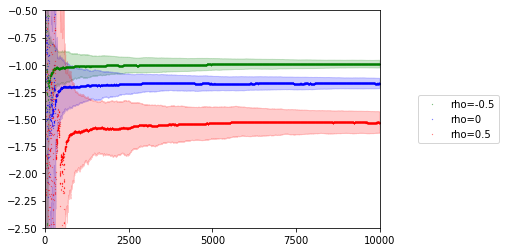

In [3]:
## plot results
fig, ax = plt.subplots()
x = np.arange(1, T+1)
ind_rho = 0
y0 = np.mean(theta_record[0, :, :], axis = 0)
y0_std = np.std(theta_record[0, :, :], axis = 0)
y1 = np.mean(theta_record[1, :, :], axis = 0)
y1_std = np.std(theta_record[1, :, :], axis = 0)
y2 = np.mean(theta_record[2, :, :], axis = 0)
y2_std = np.std(theta_record[2, :, :], axis = 0)
ax.plot(x, y0, 'o', color = 'green', markersize=0.2, label = 'rho=-0.5')
ax.fill_between(x, y0-y0_std, y0+y0_std, color = 'green', alpha=0.2)
ax.plot(x, y1, 'o', color = 'blue', markersize=0.2, label = 'rho=0')
ax.fill_between(x, y1-y1_std, y1+y1_std, color = 'blue', alpha=0.2)
ax.plot(x, y2, 'o', color = 'red', markersize=0.2, label = 'rho=0.5')
ax.fill_between(x, y2-y2_std, y2+y2_std, color = 'red', alpha=0.2)
#for ind_experiment in range(n_repeat):
    #ax.plot(x, theta_record[0, ind_experiment,:], '-', color = 'green')
    #ax.plot(x, theta_record[1, ind_experiment,:], '-', color = 'blue')
    #ax.plot(x, theta_record[2, ind_experiment,:], '-', color = 'red')
#ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
#ax.plot(x, y, 'o', color='tab:brown')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.set_xlim([0, 10000])
ax.set_xticks([0, 2500, 5000, 7500, 10000])
ax.set_ylim([-2.5, -0.5])
fig

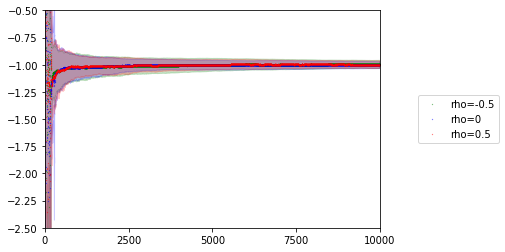

In [6]:
## plot results
fig, ax = plt.subplots()
x = np.arange(1, T+1)
ind_rho = 0
y0 = np.mean(theta_record_weighted[0, :, :], axis = 0)
y0_std = np.std(theta_record_weighted[0, :, :], axis = 0)
y1 = np.mean(theta_record_weighted[1, :, :], axis = 0)
y1_std = np.std(theta_record_weighted[1, :, :], axis = 0)
y2 = np.mean(theta_record_weighted[2, :, :], axis = 0)
y2_std = np.std(theta_record_weighted[2, :, :], axis = 0)
ax.plot(x, y0, 'o', color = 'green', markersize=0.2, label = 'rho=-0.5')
ax.fill_between(x, y0-y0_std, y0+y0_std, color = 'green', alpha=0.2)
ax.plot(x, y1, 'o', color = 'blue', markersize=0.2, label = 'rho=0')
ax.fill_between(x, y1-y1_std, y1+y1_std, color = 'blue', alpha=0.2)
ax.plot(x, y2, 'o', color = 'red', markersize=0.2, label = 'rho=0.5')
ax.fill_between(x, y2-y2_std, y2+y2_std, color = 'red', alpha=0.2)
#for ind_experiment in range(n_repeat):
    #ax.plot(x, theta_record[0, ind_experiment,:], '-', color = 'green')
    #ax.plot(x, theta_record[1, ind_experiment,:], '-', color = 'blue')
    #ax.plot(x, theta_record[2, ind_experiment,:], '-', color = 'red')
#ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
#ax.plot(x, y, 'o', color='tab:brown')
ax.set_xlim([0, 10000])
ax.set_xticks([0, 2500, 5000, 7500, 10000])
ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.set_ylim([-2.5, -0.5])
fig

In [87]:
test=np.array([[1, 2], [3, 4], [5, 6]])
print(test)
np.mean(test, axis = 1)

[[1 2]
 [3 4]
 [5 6]]


array([1.5, 3.5, 5.5])